# Image registration

A common problem when working with large collections of related images is registrating them together, relative to a reference. Thunder implements a generic image registration API that supports a variety of registration algorithms, and exposes to the user both standard approaches and the ability to implement custom solutions. Here, we generate data for registration, apply a registration algorithm, and show the results.

If you are interested in contributing a new registration algorithm to Thunder, let us know in the [chatroom](https://gitter.im/thunder-project/thunder)!

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from thunder import Colorize
image = Colorize.image
tile = Colorize.tile
sns.set_style('darkgrid')
sns.set_context('notebook')

Generating data
---------------

We will use the included toy example image data to test registration algorithms. These data do not actually have any motion, so to test the algorithms, we will induce fake motion. First we'll load and inspect the data.

In [3]:
data = tsc.loadExample('mouse-images')
data

Images
nrecords: 500
dtype: int16
dims: min=(0, 0), max=(63, 63), count=(64, 64)

There are 500 images (corresponding to 500 time points), and the data are two-dimensional, so we'll want to generate 500 random shifts in x and y. We'll use smoothing functions from scipy to make sure the drift varies slowly over time, which will be easier to look at.

In [4]:
from numpy import random
from scipy.ndimage.filters import gaussian_filter
t = 500
dx = gaussian_filter(random.randn(t), 50) * 25
dy = gaussian_filter(random.randn(t), 50) * 25

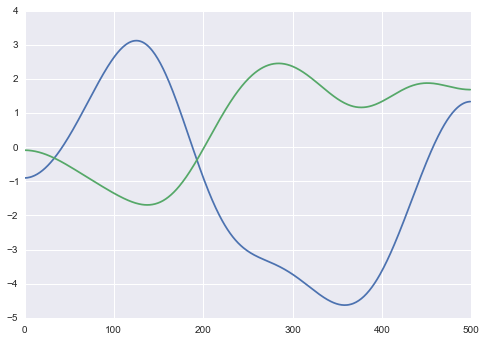

In [5]:
plt.plot(dx);
plt.plot(dy);

Now let's use these drifts to shift the data. We'll use the `apply` method on our data, which applies an arbitrary function to each record; in this case, the function is to shift by an amount given by the corresponding entry in our list of shifts.

In [6]:
from scipy.ndimage import shift
shifted = data.apply(lambda (k, v): (k, shift(v, (dx[k], dy[k]), mode='nearest', order=0)))

Look at the first entry of both the original images and the shifted images, and their difference

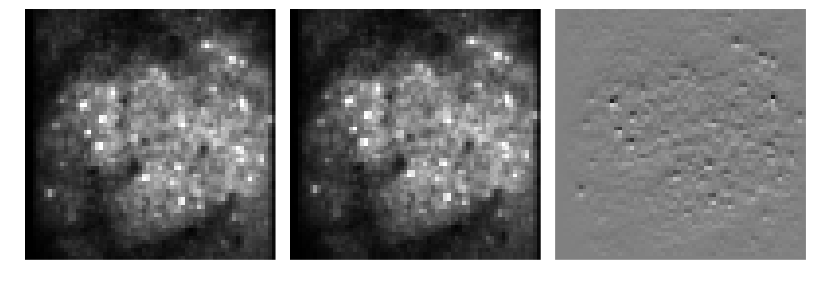

In [7]:
im1 = data[0]
im2 = shifted[0]
tile([im1, im2, im1-im2], clim=[(0,300), (0,300), (-300,300)], grid=(1,3), size=14)

It's also useful to look at the mean of the raw images and the shifted images, the mean of the shifted images should be much more blurry!

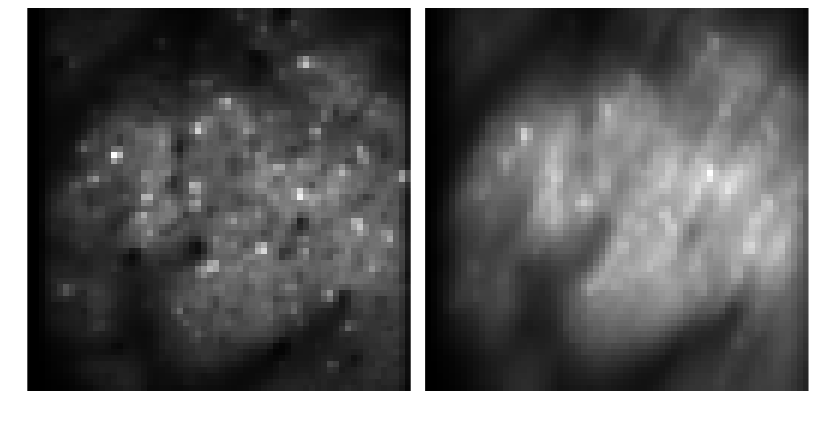

In [8]:
tile([data.mean(), shifted.mean()], size=14)

Registration
------------

To run registration, first we create a registration method by specifying its name (current options include 'crosscorr' and 'planarcrosscorr')

In [9]:
from thunder import Registration
reg = Registration('crosscorr')

This method computes a cross-correlation in parallel between every image and a reference. To compute that reference, we can use the `prepare` method, and either give it a reference, or have it compute one for us. For this method, the default `prepare` is to compute a mean, over some specified range. We call:

In [10]:
reg.prepare(shifted, startIdx=0, stopIdx=500);

This adds a `reference` attribute to the `reg` object, which we can look at

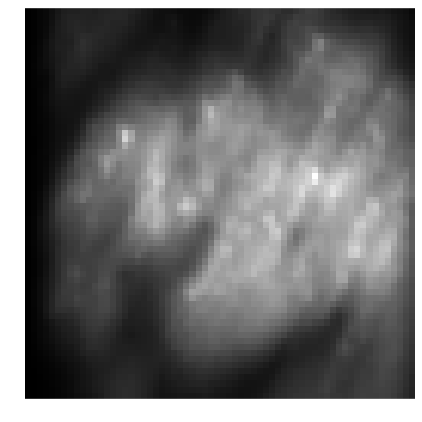

In [11]:
image(reg.reference)

We could have equivalently computed the reference ourselves (using the mean, or any other calculation) and passed it as an argument

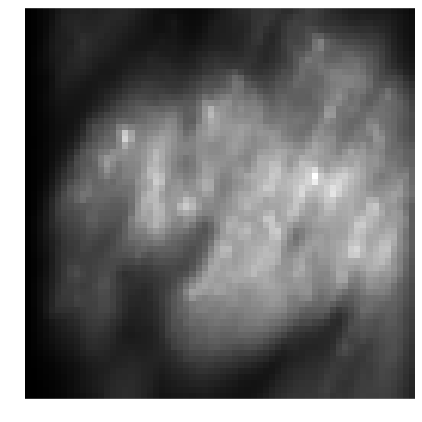

In [12]:
ref = shifted.filterOnKeys(lambda k: k > 0 and k < 500).mean()
reg.prepare(ref)
image(reg.reference)

Now we use the registration method `reg` and fit it to the shifted data, returning a fitted `RegistrationModel`

In [13]:
model = reg.fit(shifted)

Inspect the model

In [14]:
model

RegistrationModel
500 transformations
registration method: CrossCorr
transformation type: Displacement

The model represents a list of transformations. You can inspect them:

In [15]:
model[0]

Displacement(delta=[0, -1])

You can also convert the full collection of transformations into an array, which is useful for plotting. Here we'll plot the estimated transformations relative to the ground truth, they should be fairly similar.

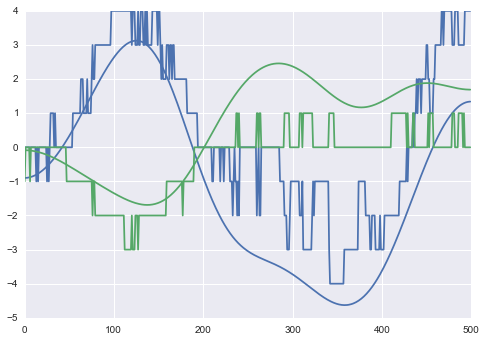

In [16]:
clrs = sns.color_palette('deep')
plt.plot(model.toArray()[:,0], color=clrs[0])
plt.plot(dx, color=clrs[0])
plt.plot(model.toArray()[:,1], color=clrs[1])
plt.plot(dy, color=clrs[1]);

Note that, while following a similar pattern as the ground truth, the estimates are not perfect. That's because we didn't use the true reference to estimate the displacements, but rather the mean of the displaced data. To see that we get the exact displacements back, let's compute a reference from the original, unshifted data.

In [17]:
reg.prepare(data, startIdx=0, stopIdx=500)
model = reg.fit(shifted)

Now the estimates should be exact (up to rounding error)! But note that this is sort of cheating, because in general we don't know the ground truth.

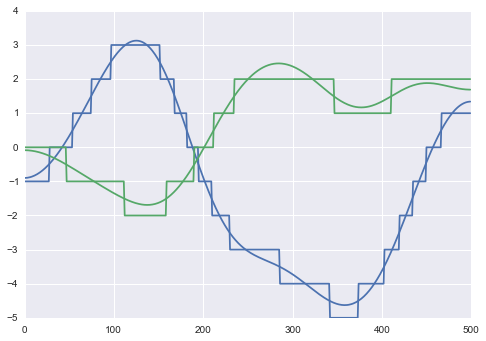

In [18]:
plt.plot(model.toArray()[:,0], color=clrs[0])
plt.plot(dx, color=clrs[0])
plt.plot(model.toArray()[:,1], color=clrs[1])
plt.plot(dy, color=clrs[1]);

We can now use our model to `transform` a set of images, which applies the estimated transformations. The API design makes it easy to apply the transformations to the dataset we used to estimate the transformations, or a different one. We'll use the model we just estimates, which used the true reference, because it will be easy to see that it did the right thing.

In [19]:
corrected = model.transform(shifted)

Let's again look at the first image from the orignal and corrected, and their difference. Whereas before they were different, now they should be the same, except for minor near the boundaries (where the image has been replaced with its nearest neighbors).

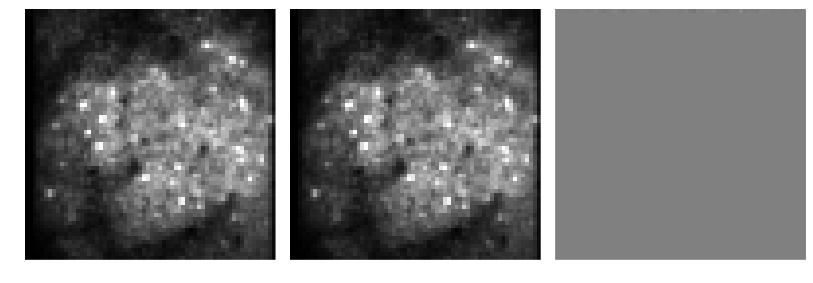

In [20]:
im1 = data[0]
im2 = corrected[0]
tile([im1, im2, im1-im2], clim=[(0,300), (0,300), (-300,300)], grid=(1,3), size=14)

As a final check on the registation, we can compare the mean of the shifted data, and the mean of the regsitered data. The latter should be much sharper.

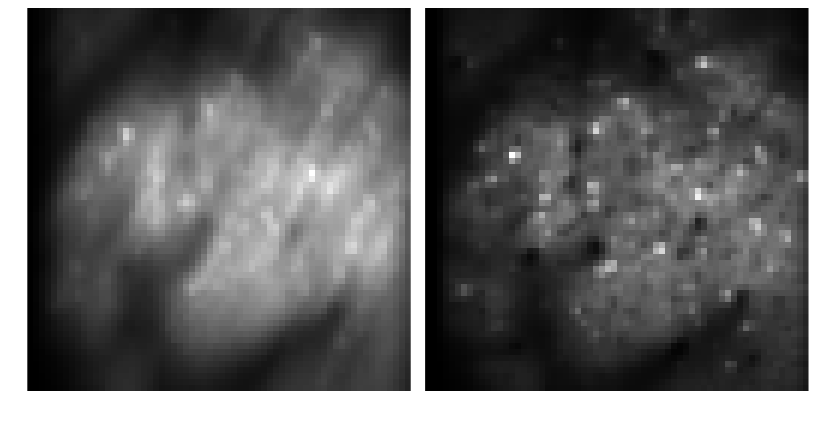

In [21]:
tile([shifted.mean(), corrected.mean()], size=14)

We can easily save the model to a JSON file, and load it back in.

```
model.save('model.json')
modelreloaded = Registration.load('model.json')
```